# Investigating the normalization for LgradB

In the paper the authors validate the performance of the LgradB metric by comparing it to the REGCOIL complexity of the configuration. This analysis uses the following normalization for REGCOIL:

    For the results that follow, we chose $\lambda$ so that $B_{RMS} = 0.01 T$, with all configurations scaled to an average field strength in the plasma of $B_0 = 5.865 T$.

where $B_0$ is the volume average magnetic field. It is unclear why the volume average would be chosen here instead of e.g. maximum field on axis.

This Python notebook compares analytic derivation for B_volume average with numerical results of shaped stellerators


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simsopt


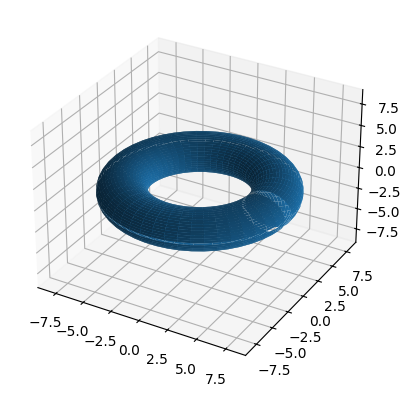

<Axes3D: >

In [37]:
from simsopt.mhd import Vmec

equil = Vmec("qifiles/wout_QI_nfp3.nc")
equil = Vmec("../tests/test_files/wout_circular_tokamak_reference.nc",)
surf = equil.boundary
surf.plot()


In [43]:
B_VOL_AVG_TARGET = 5.865 #T
magnetic_scaling = B_VOL_AVG_TARGET / equil.wout.volavgB

from scipy.io import netcdf_file
import os

filename = "wout_circular_tokamak_reference_LgradBscaling.nc"
os.system(f"cp ../tests/test_files/wout_circular_tokamak_reference.nc {filename}")

# Copy the file on disk with a new name, open with r+ and overwrite it.
with netcdf_file(filename, "a", mmap=False) as f:
    f.variables["bvco"][:] *= magnetic_scaling
    f.variables["b0"][()] *= magnetic_scaling
    f.variables["bmnc"][:] *= magnetic_scaling
    f.variables["volavgB"][()] *= magnetic_scaling
    f.variables["bsubsmns"][:] *= magnetic_scaling
    f.variables["bsubumnc"][:] *= magnetic_scaling
    f.variables["bsubvmnc"][:] *= magnetic_scaling
    f.variables["bsupumnc"][:] *= magnetic_scaling
    f.variables["bsupvmnc"][:] *= magnetic_scaling


    print(f.variables["b0"][()],  f.variables["volavgB"][()])


5.735236810255283 5.865


In [3]:
import simsopt.mhd

def B_avg_volume(vmec:simsopt.mhd.Vmec, s, nphi=64, ntheta=47):
  vs = simsopt.mhd.vmec_splines(vmec)
  nfp = vs.nfp
  # Shorthand:
  mnmax_nyq = vs.mnmax_nyq
  xm_nyq = vs.xm_nyq
  xn_nyq = vs.xn_nyq

  theta = np.linspace(0, 2*np.pi,   ntheta, False)
  phi = np.linspace(0, 2*np.pi/nfp, nphi, False)

  try:
      ns = len(s)
  except:
      s = [s]
  s = np.array(s)
  ns = len(s)
  # Handle theta
  try:
      ntheta = len(theta)
  except:
      theta = [theta]
  theta_vmec = np.array(theta)
  if theta_vmec.ndim == 1:
      ntheta = len(theta_vmec)
  elif theta_vmec.ndim == 3:
      ntheta = theta_vmec.shape[1]
  else:
      raise ValueError("theta argument must be a float, 1d array, or 3d array.")

  # Handle phi
  try:
      nphi = len(phi)
  except:
      phi = [phi]
  phi = np.array(phi)
  if phi.ndim == 1:
      nphi = len(phi)
  elif phi.ndim == 3:
      nphi = phi.shape[2]
  else:
      raise ValueError("phi argument must be a float, 1d array, or 3d array.")

  # If theta and phi are not already 3D, make them 3D:
  if theta_vmec.ndim == 1:
      theta_vmec = np.kron(np.ones((ns, 1, nphi)), theta_vmec.reshape(1, ntheta, 1))
  if phi.ndim == 1:
      phi = np.kron(np.ones((ns, ntheta, 1)), phi.reshape(1, 1, nphi))

  gmnc = np.zeros((ns, mnmax_nyq))
  bmnc = np.zeros((ns, mnmax_nyq))
  for jmn in range(mnmax_nyq):
    gmnc[:, jmn] = vs.gmnc[jmn](s)
    bmnc[:, jmn] = vs.bmnc[jmn](s)
    

  angle = xm_nyq[:, None, None, None] * theta_vmec[None, :, :, :] - xn_nyq[:, None, None, None] * phi[None, :, :, :]
  cosangle = np.cos(angle)
  modB = np.einsum('ij,jikl->ikl', bmnc, cosangle)
  sqrt_g_vmec = np.einsum('ij,jikl->ikl', gmnc, cosangle)

  # Surface average of the quantity
  dtheta = 2*np.pi / ntheta
  dphi = 2*np.pi / nfp / nphi
  V_prime = nfp * dtheta * dphi * np.sum(sqrt_g_vmec, axis=(1, 2))
  fsa_X = (np.sum(modB * sqrt_g_vmec, axis=(1, 2)) / V_prime * nfp * dtheta * dphi)

  return fsa_X


(5.360269593821393, 5.297219025283104)

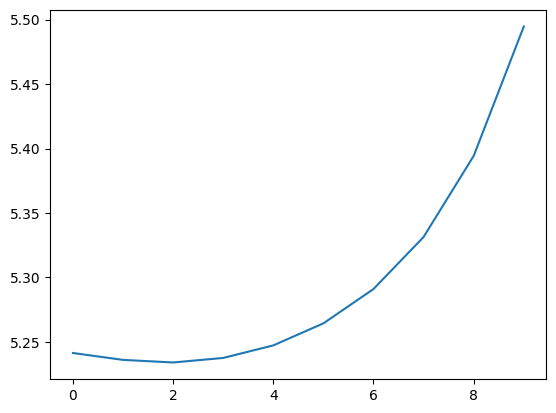

In [4]:
plt.plot(B_avg_volume(equil, np.linspace(0,1,10)))
equil.wout.volavgB, np.mean(B_avg_volume(equil, np.linspace(0,1,10)))


In [5]:
def Bv_over_Bl_analytical(R, aspect_ratio):
  Bv = 2 *aspect_ratio / R * (aspect_ratio - np.sqrt(aspect_ratio**2-1))
  Bl = 1/R
  mu_0 = 1
  I_total = 1
  Bv *= mu_0 * I_total / np.pi
  Bl *= mu_0 * I_total / np.pi
  return Bv/Bl

Bv = equil.wout.volavgB
Bv = np.mean(B_avg_volume(equil, np.linspace(0,1,10)))
Bl = np.mean(B_avg_volume(equil, np.linspace(0,.05,4)))

Bv/Bl, Bv_over_Bl_analytical(equil.wout.Rmajor_p, equil.aspect())


(1.0107849444088228, 1.0294372515228614)

../tests/test_files/wout_20220102-01-053-003_QH_nfp4_aspect6p5_beta0p05_iteratedWithSfincs_reference.nc
VMEC:  1.0218670673681884 Analytical approximation:  1.0059880903888923


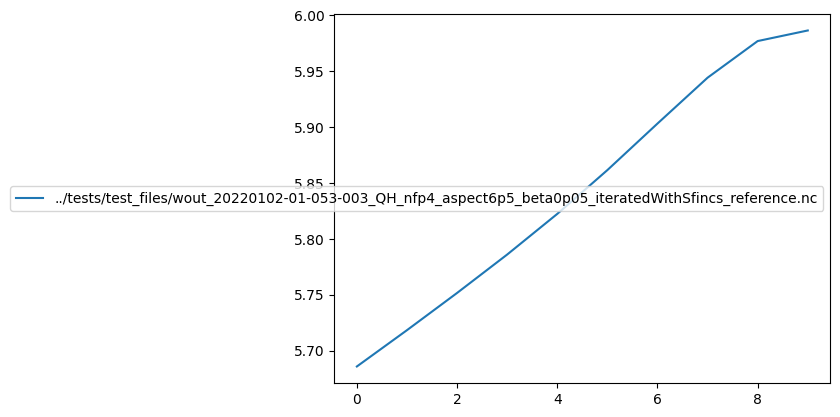

../tests/test_files/wout_ITERModel_reference.nc
VMEC:  1.0114562790580597 Analytical approximation:  1.0294372515228605


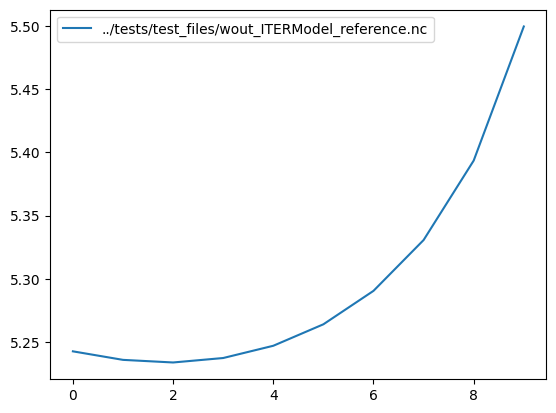

../tests/test_files/wout_LandremanPaul2021_QA_lowres.nc
VMEC:  0.9930312379435546 Analytical approximation:  1.0070425842494044


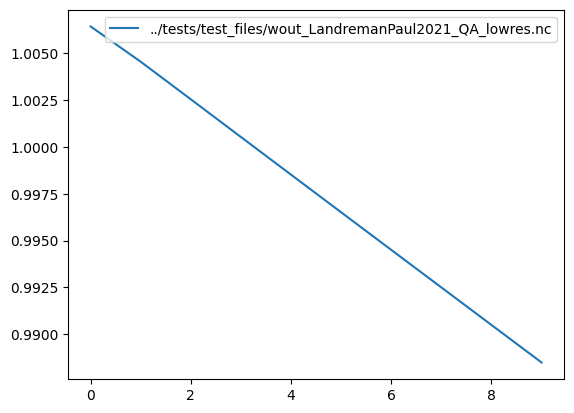

../tests/test_files/wout_LandremanPaul2021_QA_reactorScale_lowres_reference.nc
VMEC:  0.9930512392108044 Analytical approximation:  1.0070425842494006


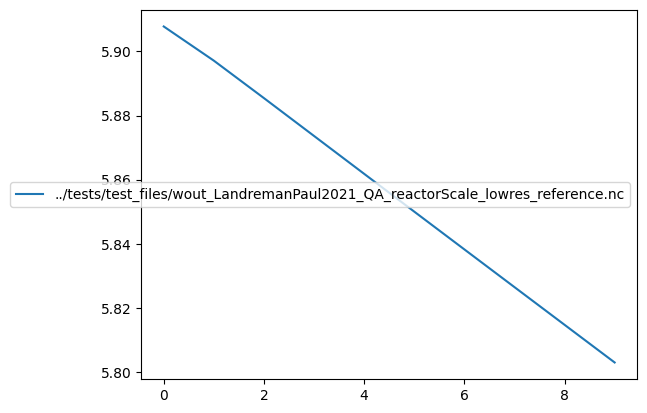

../tests/test_files/wout_LandremanPaul2021_QH_reactorScale_lowres_reference.nc
VMEC:  0.9947585118403881 Analytical approximation:  1.0039370577231104


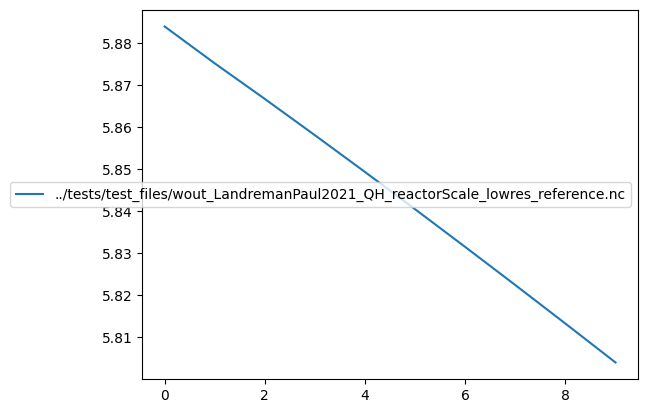

../tests/test_files/wout_LandremanSengupta2019_section5.4_B2_A80_reference.nc
VMEC:  0.9999304104139463 Analytical approximation:  1.0000467461737836


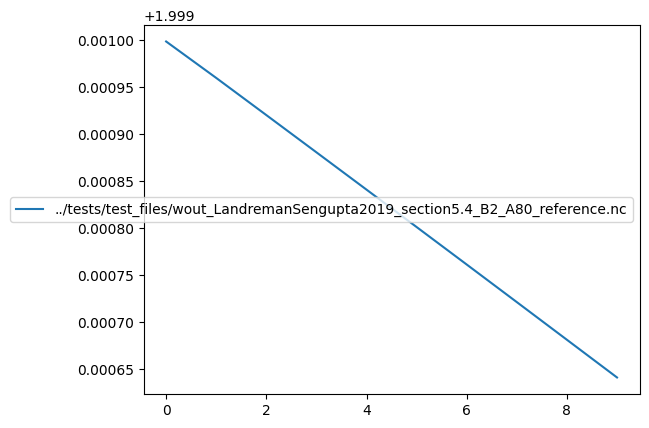

../tests/test_files/wout_W7-X_without_coil_ripple_beta0p05_d23p4_tm_reference.nc
VMEC:  1.0279077623527717 Analytical approximation:  1.0022939821926113


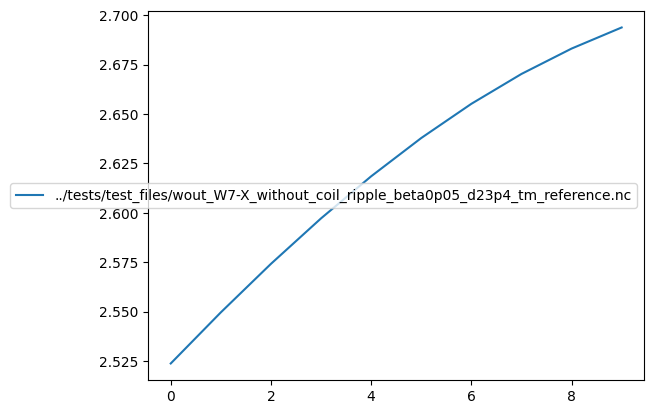

../tests/test_files/wout_c09r00_fixedBoundary_0.5T_vacuum_ns201.nc
VMEC:  0.9997246022086759 Analytical approximation:  1.012840913257892


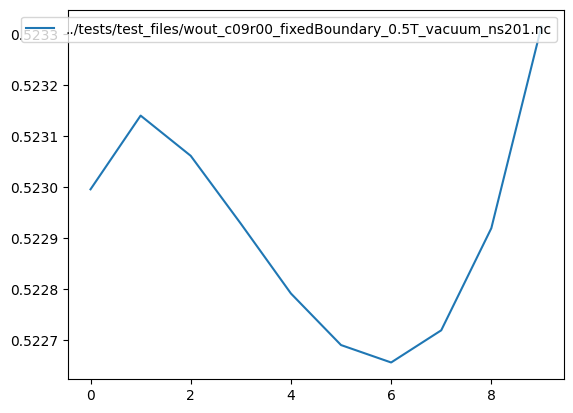

../tests/test_files/wout_circular_tokamak_aspect_100_reference.nc
VMEC:  1.0000162342192112 Analytical approximation:  1.000025001249574


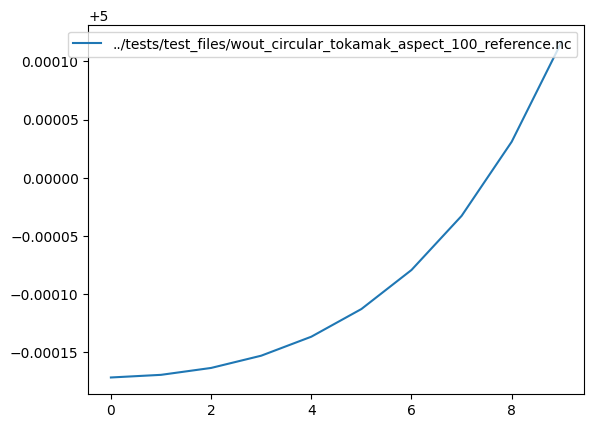

../tests/test_files/wout_circular_tokamak_reference.nc
VMEC:  1.0114662265780001 Analytical approximation:  1.0294372515228614


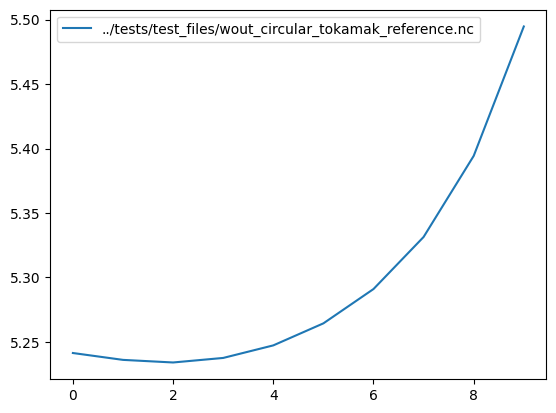

../tests/test_files/wout_li383_low_res_reference.nc
VMEC:  1.0268052362547389 Analytical approximation:  1.0135410659212523


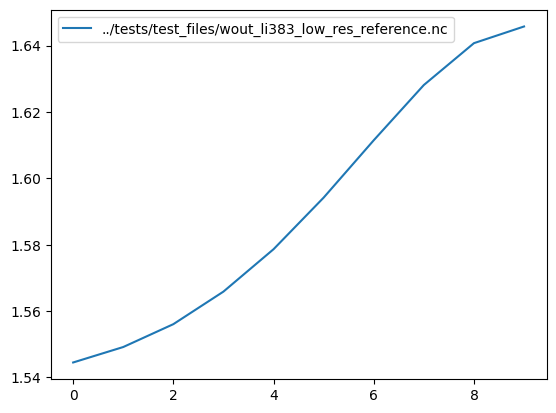

../tests/test_files/wout_n3are_R7.75B5.7.nc
VMEC:  1.0271422532263026 Analytical approximation:  1.012395047166


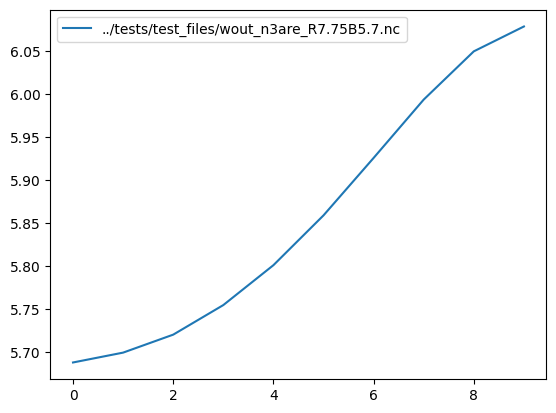

../tests/test_files/wout_n3are_R7.75B5.7_lowres.nc
VMEC:  1.0270296343929823 Analytical approximation:  1.0123886562364277


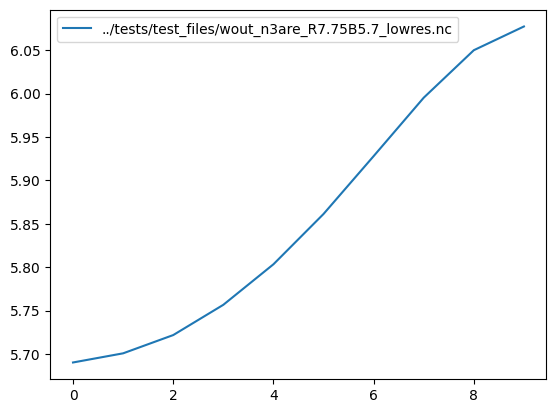

../lgradb_normalization/qifiles/wout_QI_nfp3.nc
VMEC:  0.994681795258251 Analytical approximation:  1.0039384477334994


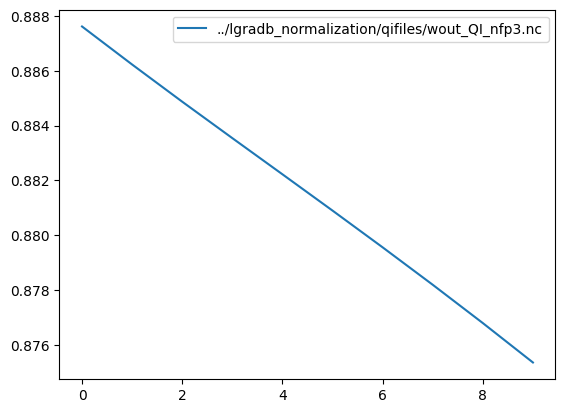

Text(0, 0.5, 'Analytic approximation')

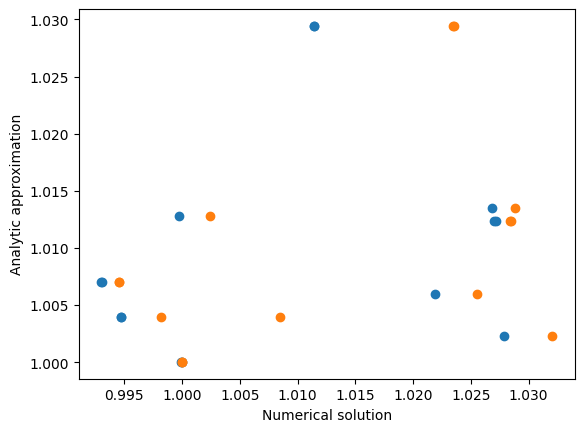

In [6]:
ref = []
ref2 = []
analytic = []

configurations = [
# "../tests/test_files/wout_10x10.nc",
"../tests/test_files/wout_20220102-01-053-003_QH_nfp4_aspect6p5_beta0p05_iteratedWithSfincs_reference.nc",
"../tests/test_files/wout_ITERModel_reference.nc",
"../tests/test_files/wout_LandremanPaul2021_QA_lowres.nc",
"../tests/test_files/wout_LandremanPaul2021_QA_reactorScale_lowres_reference.nc",
"../tests/test_files/wout_LandremanPaul2021_QH_reactorScale_lowres_reference.nc",
"../tests/test_files/wout_LandremanSengupta2019_section5.4_B2_A80_reference.nc",
# "../tests/test_files/wout_LandremanSenguptaPlunk_section5p3_reference.nc",
"../tests/test_files/wout_W7-X_without_coil_ripple_beta0p05_d23p4_tm_reference.nc",
"../tests/test_files/wout_c09r00_fixedBoundary_0.5T_vacuum_ns201.nc",
"../tests/test_files/wout_circular_tokamak_aspect_100_reference.nc",
"../tests/test_files/wout_circular_tokamak_reference.nc",
"../tests/test_files/wout_li383_low_res_reference.nc",
"../tests/test_files/wout_n3are_R7.75B5.7.nc",
"../tests/test_files/wout_n3are_R7.75B5.7_lowres.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_1.50.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_1.00.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_0.50.nc",
"../lgradb_normalization/qifiles/wout_QI_nfp3.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_3.75.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_3.50.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_3.25.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_3.00.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_2.75.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_2.50.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_2.25.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_2.00.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_1.75.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_1.25.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_0.75.nc",
# "../lgradb_normalization/qifiles/wout_nfp3_beta_0.25.nc"
]
for conf_path in configurations:
  print(conf_path)
  equil = Vmec(conf_path)


  # Flux surface averages for b
  B_fsa = B_avg_volume(equil, np.linspace(0,1,10))
  Bv = np.mean(B_fsa)
  Bl = np.mean(B_fsa[:3])

  ref.append(Bv/Bl)
  ref2.append(equil.wout.volavgB/Bl)
  analytic.append(Bv_over_Bl_analytical(equil.wout.Rmajor_p, equil.aspect()))
  print("VMEC: ", ref[-1],"Analytical approximation: ", analytic[-1])
  plt.plot(B_fsa, label=conf_path)
  plt.legend()
  plt.show()

plt.scatter(ref, analytic)
plt.scatter(ref2, analytic)
plt.xlabel("Numerical solution")
plt.ylabel("Analytic approximation")
